## Subject-wise Uncertainty Analysis on RNAseq data
### Authors: D. Tolosa, P. Joshi, R. Banda, B. Ziemann, Debajyoti Debnath

The objective of the notebook is to compute the subject-based uncertainty of the classifier <br>
The main output from this notebook is the box plot of classifier uncertainty or standard deviation <br>

**_This project was developed at The Data Mine, Purdue University, in partnership with Molecular Stethoscope._**

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.classifier import (
    sample,
    linear_classifier_score,
    antilogit_classifier_score,
    z_score,
    sample_single_patient,
)
from src.threshold import plot_uncertainty_at_threshold, plot_v_plot

In [3]:
### Reading csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
# setting index row name to the gene id
raw_data = raw_data.set_index("gene_id")
# Loading sheet 0, which contains the clinical diagnoses
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)
pathos = pathos[~pathos.loc[:, "Isolate ID"].isna()]
pathos = pathos.astype({"Isolate ID": "int"})

#### Step 1: Data Prep

In [4]:
# Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
patients_df = patients_df.filter(regex=r"^\d+")

In [5]:
# group columns by patient id
grouped_cols = patients_df.columns.str.split("-").str[0]

# group columns by patient id and r1/r2 suffixes
grouped = patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# Patients_df.head()

/tmp/ipykernel_287256/3094510434.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


#### Step 2: Computing Zscores from TPM data

In [6]:
# Computing and storing zscores
means, stds = patients_df.mean(axis=1), patients_df.iloc[:, :-1].std(axis=1)
z_scores_df = patients_df.iloc[:, :-3].apply(lambda x: z_score(x, means, stds))
z_scores_df = z_scores_df.filter(regex=r"^\d+")

#### Step 3: [Hyperparameters] We decide on number of simulations per subject (num_runs) assumed variation on TPM counts (uncertainty)
##### num_runs is the number of scores we will generate per patient, each score is generated by choosing a TPM value from a normal distribution that has the actual value as mean (or the average of the TPM counts if there are replicates) and std deviation determined by the variable 'uncertainty'.

In [7]:
num_runs = 100
pct_dev = 50  # % relative standard deviation

#### Step 4: Computing subject based uncertainty using Zscores

In [8]:
from typing import Sequence

def get_mean_std(col: Sequence[float], coefficients: Sequence[float], num_runs: int, rel_std: float) -> tuple[float, float]:
    out = sample_single_patient(col, coefficients, num_runs, rel_std)
    return np.mean(out), np.std(out)

In [9]:
# Calculating  Subject wise mean and std of simulated scores
subj_uncertainty = z_scores_df.apply(
    lambda col: pd.Series(
        get_mean_std(col, coefficients, num_runs, pct_dev), index=["mean", "uncert(SD)"]
    )
)

In [10]:
# uncomment the line below for saving as .csv

# subj_uncertainty.to_csv('data/sub-wise_uncert_' + str(RSD) + 'perc_RSD.csv')

#### Step 5: We create a boxplot for visualization of subject-wise uncertainty at the assumed %RDS, and also boxplots for AD and NCI independently

In [11]:
subj_uncert_and_pathos = subj_uncertainty.transpose()
subj_uncert_and_pathos["index1"] = subj_uncert_and_pathos.index
subj_uncert_and_pathos = subj_uncert_and_pathos.astype({"index1": "int"})
subj_uncert_and_pathos = pd.merge(
    pathos, subj_uncert_and_pathos, left_on="Isolate ID", right_on="index1"
)
subj_uncert_and_pathos = subj_uncert_and_pathos.drop(["index1"], axis=1)

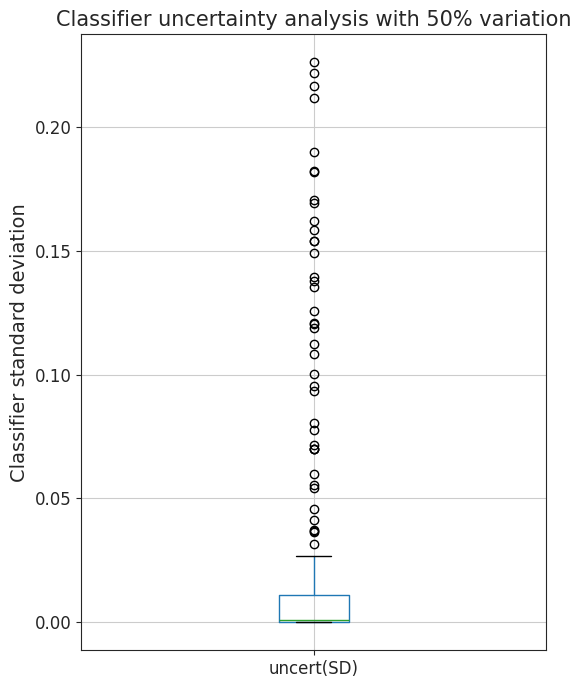

In [12]:
# Plot box plot of uncert column
subj_uncert_and_pathos.boxplot(column=["uncert(SD)"], figsize=(6, 8), fontsize=12)
plt.title(
    "Classifier uncertainty analysis with " + str(pct_dev) + "% variation", fontsize=15
)
plt.ylabel("Classifier standard deviation", fontsize=14)
plt.show()
# uncomment below  and comment above to save
# plt.savefig('box_'+str(RSD)+'perc_RSD.png')

### Below we show the same data, together with independent boxplots for AD and NCI, respectively.

In [13]:
# There is a subject who has no clinical diagnosis, uncomment the line below and run the cell to ignore this patient for the plots.
subj_uncert_and_pathos = subj_uncert_and_pathos[
    subj_uncert_and_pathos["Disease"].isin(["NCI", "AD"])
]

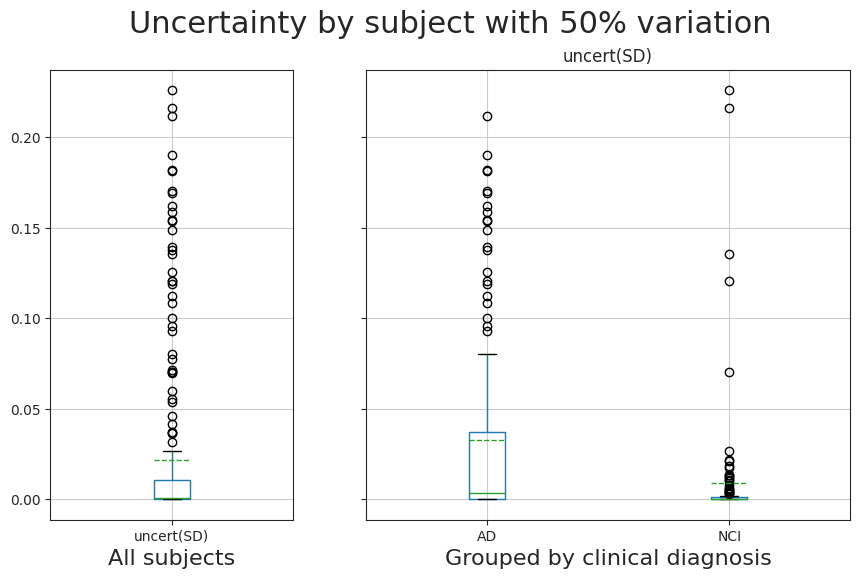

In [14]:
# boxplot for 10% variation
fig, axes = plt.subplots(
    1,
    2,
    sharex=False,
    sharey=True,
    squeeze=True,
    figsize=(10, 6),
    gridspec_kw={"width_ratios": [1, 2]},
)
box = subj_uncert_and_pathos.boxplot(
    column="uncert(SD)",
    by="Disease",
    meanline=True,
    showmeans=True,
    showcaps=True,
    showbox=True,
    showfliers=True,
    ax=axes[1],
)
subj_uncert_and_pathos.boxplot(
    column="uncert(SD)", ax=axes[0], meanline=True, showmeans=True
)
# plt.tight_layout
# axes[0].set_title('')
axes[0].set_xlabel("All subjects", fontsize=16)
axes[1].set_xlabel("Grouped by clinical diagnosis", fontsize=16)
fig.suptitle(
    "Uncertainty by subject with " + str(pct_dev) + "% variation", fontsize=22, y=1
)
# plt.savefig('box_uncert_10.png', bbox_inches='tight')
plt.show()